In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

In [2]:
MAX_SEQUENCE_LENGHT = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

### load the pretained word vectors

In [8]:
print('Loading word vectors...')
word2vec = {}
with open(os.path.join(f'./data/word2vec/glove.6B/glove.6B.{EMBEDDING_DIM}d.txt'), encoding="utf8") as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print(f'Found {len(word2vec)} word vectors')

8742it [00:00, 40860.41it/s]

Loading word vectors...


400000it [00:07, 50472.23it/s]

Found 400000 word vectors


In [9]:
word2vec['the']

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

### prepare text samples and their labels

In [10]:
train = pd.read_csv('./data/toxic-comment/train.csv')
sentences = train['comment_text'].fillna('DUMMY_VALUE').values
possible_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
targets = train[possible_labels].values

print('max seq lenght', max(len(s) for s in sentences))
print('min seq lenght', min(len(s) for s in sentences))
s = sorted(len(s) for s in sentences)
print('median seq lenght', s[len(s) // 2])

max seq lenght 5000
min seq lenght 6
median seq lenght 205


In [11]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### convert the sentences (strings) into integers

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [13]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [14]:
sequences[1]

[52,
 2635,
 13,
 555,
 3809,
 73,
 4556,
 2706,
 21,
 94,
 38,
 803,
 2679,
 992,
 589,
 8377,
 182]

### word integer mapping

In [15]:
word2idx = tokenizer.word_index
print(f'found {len(word2idx)} unique tokens.')

found 210337 unique tokens.


### pad sequences to N x T matrix

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGHT)
print(data.shape)

(159571, 100)


### prepare embedding matrix

In [17]:
print('Filling pre-trained embeddings')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            #words not found in embedding index will be all zeros
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings


In [18]:
embedding_matrix.shape

(20000, 100)

### load pre-trained word embeddings into an Emebedding layer
#### note that we set trainable = False so as to keep the embeddings fixed

In [19]:
from tensorflow.keras.layers import Layer, Embedding, Conv1D, MaxPool1D, GlobalMaxPool1D, Dense, Input, Flatten

In [20]:
# emebedding_layer = Embedding(num_words, 
#                              EMBEDDING_DIM, 
#                              weights=[embedding_matrix], 
#                              input_length=MAX_SEQUENCE_LENGHT, 
#                              trainable=False)

### model

In [21]:
DESIRED_ACCURACY = 0.9
class EarlyStopCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') > DESIRED_ACCURACY ):
            print("/nReached {}% accuracy so cancelling training! - {}".format(DESIRED_ACCURACY, logs.get('acc')))
            self.model.stop_training=True

callback = EarlyStopCallBack()

In [22]:
input_ = Input(shape=(MAX_SEQUENCE_LENGHT,))
model = tf.keras.models.Sequential([
    Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGHT, trainable=False),
    Conv1D(128, 3, activation='relu'),
    MaxPool1D(3),
    Conv1D(128, 3, activation='relu'),
    MaxPool1D(3),
    Conv1D(128, 3, activation='relu'),
    GlobalMaxPool1D(),
    Dense(128, activation='relu'),
    Dense(len(possible_labels), activation='sigmoid')
])

Instructions for updating:
Colocations handled automatically by placer.


In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 98, 128)           38528     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 128)           49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 128)            49280     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
__________

In [24]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['acc'])

## training

In [25]:
history = model.fit(data, 
                    targets, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_split=VALIDATION_SPLIT)

Train on 127656 samples, validate on 31915 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/10
127656/127656 [==============================] - 40s 310us/sample - loss: 0.0834 - acc: 0.9730 - val_loss: 0.0743 - val_acc: 0.9765
Epoch 2/10
127656/127656 [==============================] - 43s 337us/sample - loss: 0.0675 - acc: 0.9774 - val_loss: 0.0669 - val_acc: 0.9773
Epoch 3/10
127656/127656 [==============================] - 42s 331us/sample - loss: 0.0628 - acc: 0.9785 - val_loss: 0.0755 - val_acc: 0.9760
Epoch 4/10
127656/127656 [==============================] - 43s 335us/sample - loss: 0.0599 - acc: 0.9793 - val_loss: 0.0678 - val_acc: 0.9776
Epoch 5/10
127656/127656 [==============================] - 43s 338us/sample - loss: 0.0575 - acc: 0.9799 - val_loss: 0.0739 - val_acc: 0.9775
Epoch 6/10
127656/127656 [==============================] - 44s 342us/sample - loss: 0.0558 - acc: 0.9804 - 

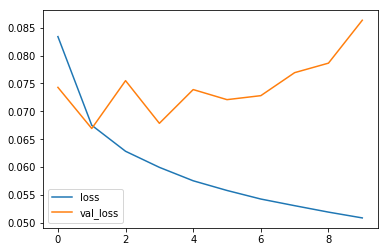

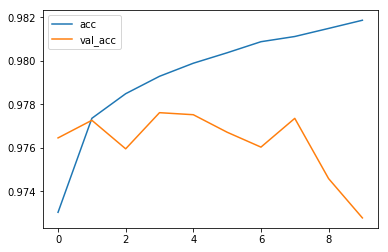

In [26]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [29]:
#plot the mean AUC over each label
from sklearn.metrics import roc_auc_score
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:, j], p[:, j])
    aucs.append(auc)
print(np.mean(aucs))

0.9691533346881395
